<a href="https://colab.research.google.com/github/harraz/covid-12-predictor/blob/main/Project_2_Less_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install tensorflow
!pip install seaborn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.5.0


In [4]:
raw_cdc_conditions_by_state=pd.read_csv("/content/drive/MyDrive/CS510/Project/cdc_agg_table_3_20210527.csv")
raw_cdc_conditions_by_state.tail()

,LocationAbbr,LocationDesc,Asthma,Poverty,OPD,Smoking,CVD
50,GU,Guam,0.0,0.0,0.000000,24.100,0.000000
51,NJ,New Jersey,61.6,10.2,1321.428571,0.000,5271.642857
52,PR,Puerto Rico,0.0,42.2,0.000000,9.675,0.000000
53,US,United States,0.0,0.0,0.000000,0.000,0.000000
54,VI,Virgin Islands,0.0,0.0,0.000000,0.000,0.000000


In [5]:
cdc_conditions_by_state=raw_cdc_conditions_by_state.copy()
cdc_conditions_by_state.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LocationAbbr  55 non-null     object 
 1   LocationDesc  55 non-null     object 
 2   Asthma        55 non-null     float64
 3   Poverty       55 non-null     float64
 4   OPD           55 non-null     float64
 5   Smoking       55 non-null     float64
 6   CVD           55 non-null     float64
dtypes: float64(5), object(2)
memory usage: 3.1+ KB


In [6]:
# load each csv file in the training data zip file and append to a raw data frame
from zipfile import ZipFile

training_files= '/content/drive/MyDrive/CS510/Project/csse_covid_19_daily_reports/training_set.zip'
test_files= '/content/drive/MyDrive/CS510/Project/csse_covid_19_daily_reports/test_data.zip'

raw_jhu_training_set = pd.concat(
    [pd.read_csv(ZipFile(training_files).open(i)) for i in ZipFile(training_files).namelist()],
    ignore_index=True
)

raw_jhu_testing_set = pd.concat(
    [pd.read_csv(ZipFile(test_files).open(i)) for i in ZipFile(test_files).namelist()],
    ignore_index=True
)

# import glob
# import os

# cols_needed=['Province_State','Deaths','Active','Confirmed','Recovered']

# path = r'/content/drive/MyDrive/CS510/Project/csse_covid_19_daily_reports/training_set'
# all_files = glob.glob(path + "/*.csv")

# all_files = glob.glob(os.path.join(path, "*.csv"))

# df_from_each_file = (pd.read_csv(f, usecols=cols_needed) for f in all_files)
# raw_jhu_training_set   = pd.concat(df_from_each_file, ignore_index=False)

# path = r'/content/drive/MyDrive/CS510/Project/csse_covid_19_daily_reports/test_data'
# all_files = glob.glob(path + "/*.csv")

# all_files = glob.glob(os.path.join(path, "*.csv"))

# df_from_each_file = (pd.read_csv(f, usecols=cols_needed) for f in all_files)
# raw_jhu_testing_set   = pd.concat(df_from_each_file, ignore_index=False)

# raw_jhu_training_set = raw_jhu_training_set[raw_jhu_training_set['Province_State']=='Pennsylvania']
# raw_jhu_training_set

# raw_jhu_testing_set = raw_jhu_testing_set[raw_jhu_testing_set['Province_State']=='Pennsylvania']

# tmp=raw_jhu_testing_set = raw_jhu_testing_set[raw_jhu_testing_set['Active'] ==0]
# tmp


In [7]:
raw_jhu_testing_set.head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incident_Rate,Case_Fatality_Ratio,Incidence_Rate,Case-Fatality_Ratio
0,NaN,NaN,NaN,Afghanistan,2021-01-07 05:22:03,33.93911,67.709953,53105,2244,42666.0,8195.0,Afghanistan,136.417321,4.225591,NaN,NaN
1,NaN,NaN,NaN,Albania,2021-01-07 05:22:03,41.15330,20.168300,61008,1217,36102.0,23689.0,Albania,2119.952742,1.994820,NaN,NaN
2,NaN,NaN,NaN,Algeria,2021-01-07 05:22:03,28.03390,1.659600,101120,2786,68383.0,29951.0,Algeria,230.598848,2.755142,NaN,NaN
3,NaN,NaN,NaN,Andorra,2021-01-07 05:22:03,42.50630,1.521800,8348,84,7615.0,649.0,Andorra,10804.374555,1.006229,NaN,NaN
4,NaN,NaN,NaN,Angola,2021-01-07 05:22:03,-11.20270,17.873900,17864,413,11477.0,5974.0,Angola,54.353600,2.311912,NaN,NaN


In [8]:
states_to_delete=['American Samoa', 'District of Columbia', 'Guam','Marshall Islands', 'Northern Mariana Island','Puerto Rico']
raw_jhu_testing_set = raw_jhu_testing_set[~raw_jhu_testing_set.Province_State.isin(states_to_delete)]
raw_jhu_training_set = raw_jhu_training_set[~raw_jhu_training_set.Province_State.isin(states_to_delete)]

us_idx=raw_jhu_testing_set[raw_jhu_testing_set['Country_Region'] !='US'].index
raw_jhu_testing_set.drop(us_idx,inplace=True)

us_idx=raw_jhu_training_set[ raw_jhu_training_set['Country_Region'] !='US'].index
raw_jhu_training_set.drop(us_idx,inplace=True)

idx=raw_jhu_training_set.query('Confirmed <= 0').index
idx2=(raw_jhu_training_set.query('Active <= 0').index)
idx.append(idx2)
raw_jhu_training_set.drop(idx,inplace=True)
raw_jhu_training_set

idx=raw_jhu_testing_set.query('Confirmed <= 0', engine='python').index
idx2=(raw_jhu_testing_set.query('Active <= 0').index)
idx.append(idx2)
raw_jhu_testing_set.drop(idx,inplace=True)

raw_jhu_training_set.fillna(0,inplace=True)
raw_jhu_testing_set.fillna(0,inplace=True)


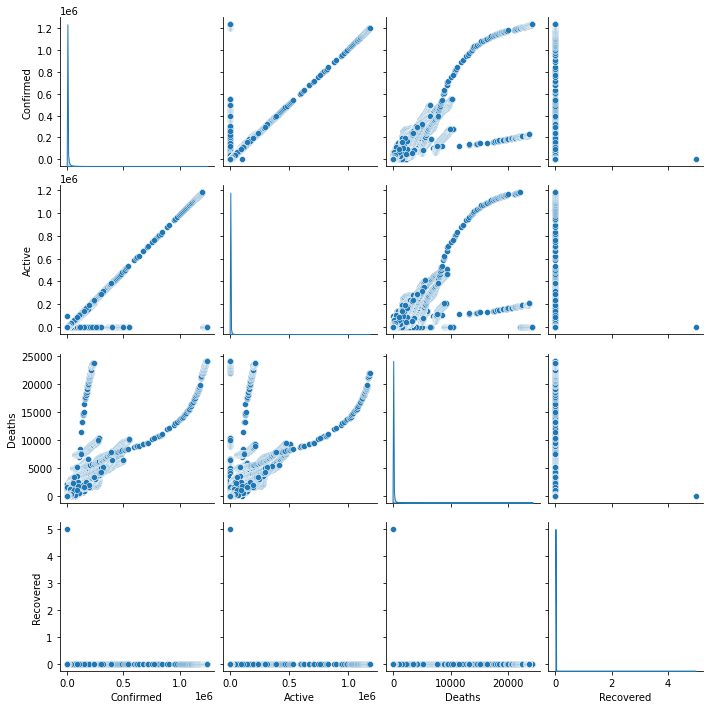

In [9]:
sns.pairplot(raw_jhu_training_set[['Confirmed','Active', 'Deaths', 'Recovered']], diag_kind='kde')

In [10]:
# join JHU training data with cdc conditions data using state
cdc_jhu_training = pd.merge(raw_jhu_training_set, cdc_conditions_by_state, left_on='Province_State', right_on='LocationDesc', how="inner")
cdc_jhu_training.drop(['LocationDesc', 'LocationAbbr'], axis=1)
cdc_jhu_training = cdc_jhu_training.get(['Province_State','Deaths','Active','Confirmed','Poverty'])


cdc_jhu_testing = pd.merge(raw_jhu_testing_set, cdc_conditions_by_state, left_on='Province_State', right_on='LocationDesc', how="inner")
cdc_jhu_testing.drop(['LocationDesc', 'LocationAbbr'], axis=1)
cdc_jhu_testing = cdc_jhu_testing.get(['Province_State','Deaths','Active','Confirmed','Poverty'])

raw_jhu_testing_set.dropna(inplace=True)
raw_jhu_training_set.dropna(inplace=True)

cdc_jhu_training
# cdc_jhu_training.to_csv('cdc_jhu_training.csv')


,Province_State,Deaths,Active,Confirmed,Poverty
0,Alabama,50.0,4189.0,4239,18.60
1,Alabama,169.0,13654.0,13823,18.60
2,Alabama,33.0,1484.0,1517,18.60
3,Alabama,46.0,1808.0,1854,18.60
4,Alabama,63.0,4630.0,4693,18.60
...,...,...,...,...,...
1052729,Wyoming,16.0,2950.0,2966,12.66
1052730,Wyoming,4.0,2134.0,2138,12.66
1052731,Wyoming,7.0,1551.0,1558,12.66
1052732,Wyoming,19.0,762.0,781,12.66


In [11]:
# one hot encoding
cdc_jhu_training['AL']= (cdc_jhu_training.Province_State == 'Alabama') * 1.0
cdc_jhu_training['AK']= (cdc_jhu_training.Province_State == 'Alaska') * 1.0
cdc_jhu_training['AZ']= (cdc_jhu_training.Province_State == 'Arizona') * 1.0
cdc_jhu_training['AR']= (cdc_jhu_training.Province_State == 'Arkansas') * 1.0
cdc_jhu_training['CA']= (cdc_jhu_training.Province_State == 'California') * 1.0
cdc_jhu_training['CO']= (cdc_jhu_training.Province_State == 'Colorado') * 1.0
cdc_jhu_training['CT']= (cdc_jhu_training.Province_State == 'Connecticut') * 1.0
cdc_jhu_training['DE']= (cdc_jhu_training.Province_State == 'Delaware') * 1.0
cdc_jhu_training['FL']= (cdc_jhu_training.Province_State == 'Florida') * 1.0
cdc_jhu_training['GA']= (cdc_jhu_training.Province_State == 'Georgia') * 1.0
cdc_jhu_training['HI']= (cdc_jhu_training.Province_State == 'Hawaii') * 1.0
cdc_jhu_training['ID']= (cdc_jhu_training.Province_State == 'Idaho') * 1.0
cdc_jhu_training['IL']= (cdc_jhu_training.Province_State == 'Illinois') * 1.0
cdc_jhu_training['IN']= (cdc_jhu_training.Province_State == 'Indiana') * 1.0
cdc_jhu_training['IA']= (cdc_jhu_training.Province_State == 'Iowa') * 1.0
cdc_jhu_training['KS']= (cdc_jhu_training.Province_State == 'Kansas') * 1.0
cdc_jhu_training['KY']= (cdc_jhu_training.Province_State == 'Kentucky') * 1.0
cdc_jhu_training['LA']= (cdc_jhu_training.Province_State == 'Louisiana') * 1.0
cdc_jhu_training['ME']= (cdc_jhu_training.Province_State == 'Maine') * 1.0
cdc_jhu_training['MD']= (cdc_jhu_training.Province_State == 'Maryland') * 1.0
cdc_jhu_training['MA']= (cdc_jhu_training.Province_State == 'Massachusetts') * 1.0
cdc_jhu_training['MI']= (cdc_jhu_training.Province_State == 'Michigan') * 1.0
cdc_jhu_training['MN']= (cdc_jhu_training.Province_State == 'Minnesota') * 1.0
cdc_jhu_training['MS']= (cdc_jhu_training.Province_State == 'Mississippi') * 1.0
cdc_jhu_training['MO']= (cdc_jhu_training.Province_State == 'Missouri') * 1.0
cdc_jhu_training['MT']= (cdc_jhu_training.Province_State == 'Montana') * 1.0
cdc_jhu_training['NE']= (cdc_jhu_training.Province_State == 'Nebraska') * 1.0
cdc_jhu_training['NV']= (cdc_jhu_training.Province_State == 'Nevada') * 1.0
cdc_jhu_training['NH']= (cdc_jhu_training.Province_State == 'New Hampshire') * 1.0
cdc_jhu_training['NJ']= (cdc_jhu_training.Province_State == 'New Jersey') * 1.0
cdc_jhu_training['NM']= (cdc_jhu_training.Province_State == 'New Mexico') * 1.0
cdc_jhu_training['NY']= (cdc_jhu_training.Province_State == 'New York') * 1.0
cdc_jhu_training['NC']= (cdc_jhu_training.Province_State == 'North Carolina') * 1.0
cdc_jhu_training['ND']= (cdc_jhu_training.Province_State == 'North Dakota') * 1.0
cdc_jhu_training['OH']= (cdc_jhu_training.Province_State == 'Ohio') * 1.0
cdc_jhu_training['OK']= (cdc_jhu_training.Province_State == 'Oklahoma') * 1.0
cdc_jhu_training['OR']= (cdc_jhu_training.Province_State == 'Oregon') * 1.0
cdc_jhu_training['PA']= (cdc_jhu_training.Province_State == 'Pennsylvania') * 1.0
cdc_jhu_training['RI']= (cdc_jhu_training.Province_State == 'Rhode Island') * 1.0
cdc_jhu_training['SC']= (cdc_jhu_training.Province_State == 'South Carolina') * 1.0
cdc_jhu_training['SD']= (cdc_jhu_training.Province_State == 'South Dakota') * 1.0
cdc_jhu_training['TN']= (cdc_jhu_training.Province_State == 'Tennessee') * 1.0
cdc_jhu_training['TX']= (cdc_jhu_training.Province_State == 'Texas') * 1.0
cdc_jhu_training['UT']= (cdc_jhu_training.Province_State == 'Utah') * 1.0
cdc_jhu_training['VT']= (cdc_jhu_training.Province_State == 'Vermont') * 1.0
cdc_jhu_training['VA']= (cdc_jhu_training.Province_State == 'Virginia') * 1.0
cdc_jhu_training['WA']= (cdc_jhu_training.Province_State == 'Washington') * 1.0
cdc_jhu_training['WV']= (cdc_jhu_training.Province_State == 'West Virginia') * 1.0
cdc_jhu_training['WI']= (cdc_jhu_training.Province_State == 'Wisconsin') * 1.0
cdc_jhu_training['WY']= (cdc_jhu_training.Province_State == 'Wyoming') * 1.0
# cdc_jhu_training['AS']= (cdc_jhu_training.Province_State == 'American Samoa') * 1.0
# cdc_jhu_training['DC']= (cdc_jhu_training.Province_State == 'District of Columbia') * 1.0
# cdc_jhu_training['GU']= (cdc_jhu_training.Province_State == 'Guam') * 1.0
# cdc_jhu_training['MH']= (cdc_jhu_training.Province_State == 'Marshall Islands') * 1.0
# cdc_jhu_training['MP']= (cdc_jhu_training.Province_State == 'Northern Mariana Island') * 1.0
# cdc_jhu_training['PR']= (cdc_jhu_training.Province_State == 'Puerto Rico') * 1.0

# do the same for test data set
cdc_jhu_testing['AL']= (cdc_jhu_testing.Province_State == 'Alabama') * 1.0
cdc_jhu_testing['AK']= (cdc_jhu_testing.Province_State == 'Alaska') * 1.0
cdc_jhu_testing['AZ']= (cdc_jhu_testing.Province_State == 'Arizona') * 1.0
cdc_jhu_testing['AR']= (cdc_jhu_testing.Province_State == 'Arkansas') * 1.0
cdc_jhu_testing['CA']= (cdc_jhu_testing.Province_State == 'California') * 1.0
cdc_jhu_testing['CO']= (cdc_jhu_testing.Province_State == 'Colorado') * 1.0
cdc_jhu_testing['CT']= (cdc_jhu_testing.Province_State == 'Connecticut') * 1.0
cdc_jhu_testing['DE']= (cdc_jhu_testing.Province_State == 'Delaware') * 1.0
cdc_jhu_testing['FL']= (cdc_jhu_testing.Province_State == 'Florida') * 1.0
cdc_jhu_testing['GA']= (cdc_jhu_testing.Province_State == 'Georgia') * 1.0
cdc_jhu_testing['HI']= (cdc_jhu_testing.Province_State == 'Hawaii') * 1.0
cdc_jhu_testing['ID']= (cdc_jhu_testing.Province_State == 'Idaho') * 1.0
cdc_jhu_testing['IL']= (cdc_jhu_testing.Province_State == 'Illinois') * 1.0
cdc_jhu_testing['IN']= (cdc_jhu_testing.Province_State == 'Indiana') * 1.0
cdc_jhu_testing['IA']= (cdc_jhu_testing.Province_State == 'Iowa') * 1.0
cdc_jhu_testing['KS']= (cdc_jhu_testing.Province_State == 'Kansas') * 1.0
cdc_jhu_testing['KY']= (cdc_jhu_testing.Province_State == 'Kentucky') * 1.0
cdc_jhu_testing['LA']= (cdc_jhu_testing.Province_State == 'Louisiana') * 1.0
cdc_jhu_testing['ME']= (cdc_jhu_testing.Province_State == 'Maine') * 1.0
cdc_jhu_testing['MD']= (cdc_jhu_testing.Province_State == 'Maryland') * 1.0
cdc_jhu_testing['MA']= (cdc_jhu_testing.Province_State == 'Massachusetts') * 1.0
cdc_jhu_testing['MI']= (cdc_jhu_testing.Province_State == 'Michigan') * 1.0
cdc_jhu_testing['MN']= (cdc_jhu_testing.Province_State == 'Minnesota') * 1.0
cdc_jhu_testing['MS']= (cdc_jhu_testing.Province_State == 'Mississippi') * 1.0
cdc_jhu_testing['MO']= (cdc_jhu_testing.Province_State == 'Missouri') * 1.0
cdc_jhu_testing['MT']= (cdc_jhu_testing.Province_State == 'Montana') * 1.0
cdc_jhu_testing['NE']= (cdc_jhu_testing.Province_State == 'Nebraska') * 1.0
cdc_jhu_testing['NV']= (cdc_jhu_testing.Province_State == 'Nevada') * 1.0
cdc_jhu_testing['NH']= (cdc_jhu_testing.Province_State == 'New Hampshire') * 1.0
cdc_jhu_testing['NJ']= (cdc_jhu_testing.Province_State == 'New Jersey') * 1.0
cdc_jhu_testing['NM']= (cdc_jhu_testing.Province_State == 'New Mexico') * 1.0
cdc_jhu_testing['NY']= (cdc_jhu_testing.Province_State == 'New York') * 1.0
cdc_jhu_testing['NC']= (cdc_jhu_testing.Province_State == 'North Carolina') * 1.0
cdc_jhu_testing['ND']= (cdc_jhu_testing.Province_State == 'North Dakota') * 1.0
cdc_jhu_testing['OH']= (cdc_jhu_testing.Province_State == 'Ohio') * 1.0
cdc_jhu_testing['OK']= (cdc_jhu_testing.Province_State == 'Oklahoma') * 1.0
cdc_jhu_testing['OR']= (cdc_jhu_testing.Province_State == 'Oregon') * 1.0
cdc_jhu_testing['PA']= (cdc_jhu_testing.Province_State == 'Pennsylvania') * 1.0
cdc_jhu_testing['RI']= (cdc_jhu_testing.Province_State == 'Rhode Island') * 1.0
cdc_jhu_testing['SC']= (cdc_jhu_testing.Province_State == 'South Carolina') * 1.0
cdc_jhu_testing['SD']= (cdc_jhu_testing.Province_State == 'South Dakota') * 1.0
cdc_jhu_testing['TN']= (cdc_jhu_testing.Province_State == 'Tennessee') * 1.0
cdc_jhu_testing['TX']= (cdc_jhu_testing.Province_State == 'Texas') * 1.0
cdc_jhu_testing['UT']= (cdc_jhu_testing.Province_State == 'Utah') * 1.0
cdc_jhu_testing['VT']= (cdc_jhu_testing.Province_State == 'Vermont') * 1.0
cdc_jhu_testing['VA']= (cdc_jhu_testing.Province_State == 'Virginia') * 1.0
cdc_jhu_testing['WA']= (cdc_jhu_testing.Province_State == 'Washington') * 1.0
cdc_jhu_testing['WV']= (cdc_jhu_testing.Province_State == 'West Virginia') * 1.0
cdc_jhu_testing['WI']= (cdc_jhu_testing.Province_State == 'Wisconsin') * 1.0
cdc_jhu_testing['WY']= (cdc_jhu_testing.Province_State == 'Wyoming') * 1.0
# cdc_jhu_testing['AS']= (cdc_jhu_testing.Province_State == 'American Samoa') * 1.0
# cdc_jhu_testing['DC']= (cdc_jhu_testing.Province_State == 'District of Columbia') * 1.0
# cdc_jhu_testing['GU']= (cdc_jhu_testing.Province_State == 'Guam') * 1.0
# cdc_jhu_testing['MH']= (cdc_jhu_testing.Province_State == 'Marshall Islands') * 1.0
# cdc_jhu_testing['MP']= (cdc_jhu_testing.Province_State == 'Northern Mariana Island') * 1.0
# cdc_jhu_testing['PR']= (cdc_jhu_testing.Province_State == 'Puerto Rico') * 1.0


In [12]:
cdc_jhu_training

,Province_State,Deaths,Active,Confirmed,Poverty,AL,AK,AZ,AR,CA,CO,CT,DE,FL,GA,HI,ID,IL,IN,IA,KS,KY,LA,ME,MD,MA,MI,MN,MS,MO,MT,NE,NV,NH,NJ,NM,NY,NC,ND,OH,OK,OR,PA,RI,SC,SD,TN,TX,UT,VT,VA,WA,WV,WI,WY
0,Alabama,50.0,4189.0,4239,18.60,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Alabama,169.0,13654.0,13823,18.60,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Alabama,33.0,1484.0,1517,18.60,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Alabama,46.0,1808.0,1854,18.60,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Alabama,63.0,4630.0,4693,18.60,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1052729,Wyoming,16.0,2950.0,2966,12.66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1052730,Wyoming,4.0,2134.0,2138,12.66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1052731,Wyoming,7.0,1551.0,1558,12.66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1052732,Wyoming,19.0,762.0,781,12.66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [13]:
# drop some state columns 
# cdc_jhu_training.drop(cdc_jhu_training.columns[7:],axis=1,inplace=True)

# cdc_jhu_testing.drop(cdc_jhu_testing.columns[7:],axis=1,inplace=True)

cdc_jhu_training.pop('Province_State')
cdc_jhu_testing.pop('Province_State')
cdc_jhu_training.describe()

,Deaths,Active,Confirmed,Poverty,AL,AK,AZ,AR,CA,CO,CT,DE,FL,GA,HI,ID,IL,IN,IA,KS,KY,LA,ME,MD,MA,MI,MN,MS,MO,MT,NE,NV,NH,NJ,NM,NY,NC,ND,OH,OK,OR,PA,RI,SC,SD,TN,TX,UT,VT,VA,WA,WV,WI,WY
count,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06,1.052734e+06
mean,9.204196e+01,2.527087e+03,4.555723e+03,1.420277e+01,2.178708e-02,8.154957e-03,4.963267e-03,2.442782e-02,1.873788e-02,2.061109e-02,2.950413e-03,1.294724e-03,2.212145e-02,5.219647e-02,1.678487e-03,1.352668e-02,3.290955e-02,2.991259e-02,3.169937e-02,3.186750e-02,3.815684e-02,2.121144e-02,5.469568e-03,7.863335e-03,4.602302e-03,2.791303e-02,2.788359e-02,2.671425e-02,3.653535e-02,1.583781e-02,2.749507e-02,5.137100e-03,3.568803e-03,7.220247e-03,1.061237e-02,1.993476e-02,3.245834e-02,1.598409e-02,2.854377e-02,2.462255e-02,1.135425e-02,2.181938e-02,1.972008e-03,1.504369e-02,1.991101e-02,3.138400e-02,7.892687e-02,4.438918e-03,4.892024e-03,4.263755e-02,1.299189e-02,1.730827e-02,2.304096e-02,7.346585e-03
std,4.862084e+02,1.443556e+04,2.176896e+04,2.446131e+00,1.459878e-01,8.993587e-02,7.027544e-02,1.543733e-01,1.355979e-01,1.420785e-01,5.423754e-02,3.595899e-02,1.470786e-01,2.224231e-01,4.093496e-02,1.155150e-01,1.783999e-01,1.703463e-01,1.751986e-01,1.756473e-01,1.915749e-01,1.440886e-01,7.375403e-02,8.832616e-02,6.768401e-02,1.647238e-01,1.646394e-01,1.612471e-01,1.876181e-01,1.248479e-01,1.635210e-01,7.148927e-02,5.963279e-02,8.466476e-02,1.024683e-01,1.397762e-01,1.772141e-01,1.254138e-01,1.665204e-01,1.549720e-01,1.059497e-01,1.460935e-01,4.436351e-02,1.217267e-01,1.396946e-01,1.743533e-01,2.696247e-01,6.647720e-02,6.977175e-02,2.020387e-01,1.132392e-01,1.304174e-01,1.500336e-01,8.539684e-02
min,0.000000e+00,-2.087000e+03,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,2.000000e+00,1.000000e+02,1.264000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.200000e+01,1.670000e+02,6.670000e+02,1.422000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0000

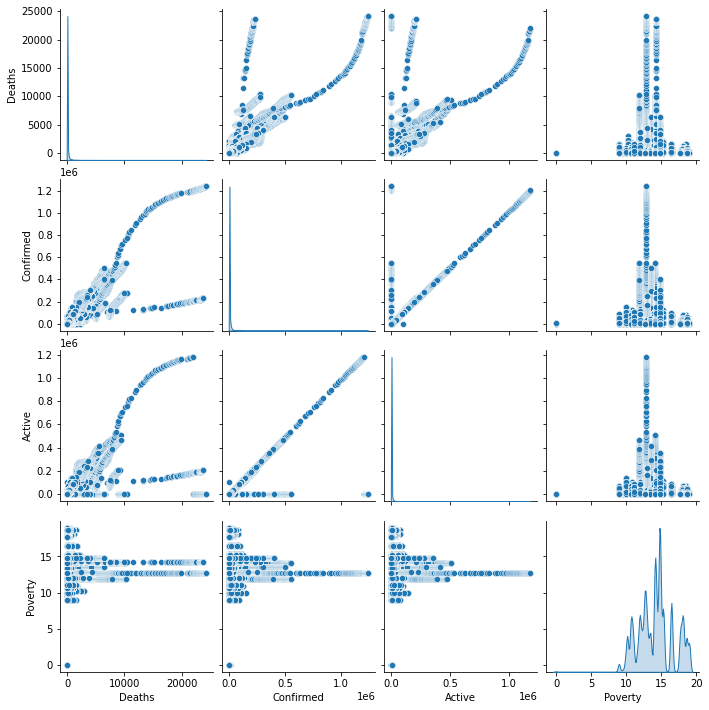

In [14]:
sns.pairplot(cdc_jhu_training[['Deaths','Confirmed','Active','Poverty']], diag_kind='kde')

In [15]:
train_stats = cdc_jhu_training.describe()
train_stats.pop('Deaths')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Active,1052734.0,2527.087164,14435.561659,-2087.0,2.00,167.00,1167.00,1179853.0
Confirmed,1052734.0,4555.722925,21768.958895,1.0,100.00,667.00,2564.00,1239127.0
Poverty,1052734.0,14.202770,2.446131,0.0,12.64,14.22,15.32,19.0
AL,1052734.0,0.021787,0.145988,0.0,0.00,0.00,0.00,1.0
AK,1052734.0,0.008155,0.089936,0.0,0.00,0.00,0.00,1.0
AZ,1052734.0,0.004963,0.070275,0.0,0.00,0.00,0.00,1.0
AR,1052734.0,0.024428,0.154373,0.0,0.00,0.00,0.00,1.0
CA,1052734.0,0.018738,0.135598,0.0,0.00,0.00,0.00,1.0
CO,1052734.0,0.020611,0.142078,0.0,0.00,0.00,0.00,1.0
CT,1052734.0,0.002950,0.054238,0.0,0.00,0.00,0.00,1.0


In [16]:
train_labels = cdc_jhu_training.pop('Deaths')
test_labels = cdc_jhu_testing.pop('Deaths')

train_labels

0           50.0
1          169.0
2           33.0
3           46.0
4           63.0
           ...  
1052729     16.0
1052730      4.0
1052731      7.0
1052732     19.0
1052733      2.0
Name: Deaths, Length: 1052734, dtype: float64

In [17]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(cdc_jhu_training)
normed_test_data = norm(cdc_jhu_testing)

In [41]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.sigmoid, input_shape=[len(normed_train_data.keys())]),
    layers.Dense(64, activation=tf.nn.sigmoid),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.05)

  # optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mse','mae'])
  return model

In [42]:
model=build_model()

In [43]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 64)                3456      
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 7,681
Trainable params: 7,681
Non-trainable params: 0
_________________________________________________________________


In [44]:
example_batch = normed_train_data[:10]
example_batch

example_result = model.predict(example_batch)
example_result


array([[-0.71402806],
       [-0.7174918 ],
       [-0.71293026],
       [-0.71306175],
       [-0.71420026],
       [-0.7126748 ],
       [-0.7129247 ],
       [-0.71600556],
       [-0.7132618 ],
       [-0.7129008 ]], dtype=float32)

In [45]:
# display training progress
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 100
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(
    x=normed_train_data, y=train_labels, batch_size=None, epochs=EPOCHS, verbose='auto',
    callbacks=[early_stop], validation_split=0.2, validation_data=None, shuffle=True,
    class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None,
    validation_steps=None, validation_batch_size=None, validation_freq=1,
    max_queue_size=10, workers=1, use_multiprocessing=True
)

# history = model.fit(
#     normed_train_data, train_labels, 
#     epochs=EPOCHS, validation_split = 0.2, verbose=0,
#     callbacks=[PrintDot()])

Epoch 1/100
26319/26319 [==============================] - 72s 3ms/step - loss: 106074.0703 - mse: 106074.0703 - mae: 41.0968 - val_loss: 9981506.0000 - val_mse: 9981506.0000 - val_mae: 1761.8188
Epoch 2/100
26319/26319 [==============================] - 67s 3ms/step - loss: 63957.3047 - mse: 63957.3047 - mae: 38.0201 - val_loss: 5717927.0000 - val_mse: 5717927.0000 - val_mae: 1192.0780
Epoch 3/100
26319/26319 [==============================] - 71s 3ms/step - loss: 54745.6992 - mse: 54745.6992 - mae: 37.5342 - val_loss: 4313323.5000 - val_mse: 4313323.5000 - val_mae: 975.6387
Epoch 4/100
26319/26319 [==============================] - 71s 3ms/step - loss: 51301.1641 - mse: 51301.1641 - mae: 37.8443 - val_loss: 2320275.2500 - val_mse: 2320275.2500 - val_mae: 715.3485
Epoch 5/100
26319/26319 [==============================] - 67s 3ms/step - loss: 44284.2852 - mse: 44284.2852 - mae: 37.6133 - val_loss: 2333132.5000 - val_mse: 2333132.5000 - val_mae: 729.7546
Epoch 6/100
26319/26319 [======

In [46]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mse,mae,val_loss,val_mse,val_mae,epoch
25,28645.597656,28645.597656,38.388763,1306210.875,1306210.875,724.399719,25
26,26596.841797,26596.841797,39.402382,1154387.500,1154387.500,708.519043,26
27,26202.714844,26202.714844,39.184490,1082516.500,1082516.500,770.488586,27
28,25577.021484,25577.021484,39.120205,1254046.625,1254046.625,791.048767,28
29,26473.136719,26473.136719,38.947350,1107109.750,1107109.750,670.119873,29


In [47]:
history.history.keys()

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])

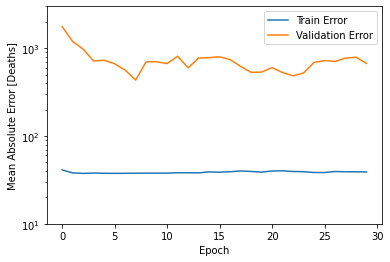

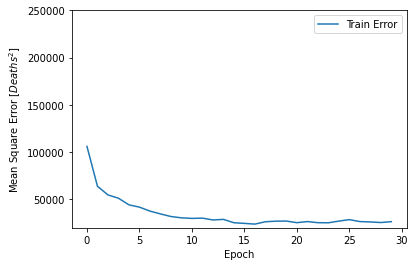

In [48]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Error [Deaths]') 
  plt.plot(hist['epoch'], hist['mae'], label ='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'], label = 'Validation Error')
  plt.gca()
  plt.yscale('log')
  plt.legend()
  plt.ylim([10,3000])

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$Deaths^2$]') 
  plt.plot(hist['epoch'], hist['mse'], label ='Train Error')
  # plt.plot(hist['epoch'], hist['val_mse'], label = 'Validation Mean Squared Error')
  # plt.yscale('log')
  plt.legend()
  plt.ylim([20000,250000])
plot_history(history)


In [49]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)
print("Testing set mean Absolute Error: {:5.7f} Deaths".format(mae))

#Testing set mean Absolute Error: 2393219.0000000 Deaths
#Testing set mean Absolute Error: 1033921.6250000 Deaths (add layer)
#Testing set mean Absolute Error: 1637497.3750000 Deaths (remove layer and use sigmoid)
#Testing set mean Absolute Error: 582547.6250000 Deaths
#Testing set mean Absolute Error: 1449834.2500000 Deaths
#Testing set mean Absolute Error: 1420743.2500000 Deaths (added layer and patience to 20)
# Testing set mean Absolute Error: 991202.8750000 Deaths (changed optimizer to )


Testing set mean Absolute Error: 252535.6406250 Deaths


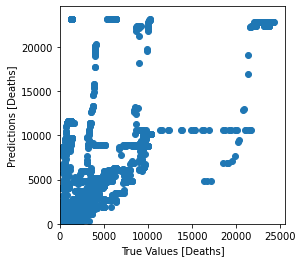

In [50]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel("True Values [Deaths]")
plt.ylabel("Predictions [Deaths]")
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-10,10],[-10,10])

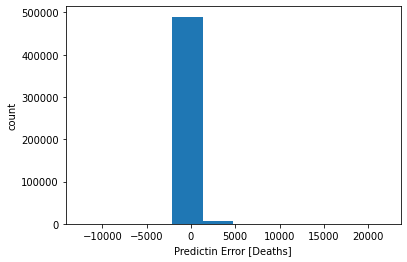

In [51]:
err = test_predictions - test_labels
plt.hist(err, bins=10)
plt.xlabel("Predictin Error [Deaths]")
_ = plt.ylabel("count")